In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import numpy as np
import pandas as pd
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.
Importing plotly failed. Interactive plots will not work.


In [10]:
def create_files_dict(pth='./sp500/'):
    
    files = os.listdir(pth)
    print(files)
    all_data = dict()
    
    for file in files:
        
        # create key and file path
        file_key = file.split('_')[0]
        file_path = os.path.join(pth, file)
        data = pd.read_csv(file_path, index_col='Date', parse_dates=['Date'] )
        all_data[file_key] = data
    
    return all_data

In [11]:
def plot_data(data, stock_name, pth='./figures/'):
    
    data["High"][:'2016'].plot(figsize=(16, 4), legend=True)
    data["High"]['2017':].plot(figsize=(16, 4), legend=True)
    
    plt.legend(['Training set (Before 2016)', 'Test set (Beyond 2017)'])
    plt.title('{} stock price'.format(stock_name))
    
    fig_path = os.path.join(pth, stock_name + '_train_test')
    
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()  

In [12]:
def create_dl_train_test_split(all_data):
    
    # these two lines create the training and test set data on high values
    training_set = all_data[:'2020-08-21'].iloc[:, 1:2].values
    test_set = all_data['2020-08-24':].iloc[:, 1:2].values
    
    #these lines scale the data
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    
    #scaling the train and test data
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    
    #create training and test data
    X_train = []
    y_train = []
    
    # 2769 is the length of the obs, better to automate, 60 is ok
    for i in range(60, 2768):
    
        X_train.append(training_set_scaled[i - 60:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    total_data = pd.concat((all_data["High"][:'2020-08-21'], all_data["High"]['2020-08-24':]), axis=0)
    inputs = total_data[len(total_data) - len(test_set) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test
    X_test = []

    for i in range(60, 311):
        X_test.append(inputs[i - 60:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc

In [13]:
def create_single_layer_small_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    
    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)
    
    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [14]:
def create_single_layer_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    
    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)
    
    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)
    
    return model, test_preds

In [15]:
def create_rnn_model(X_train, y_train, X_test, sc):
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    
    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)
    
    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds

In [16]:
def create_GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price

In [17]:
def create_GRU_with_drop_out_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    
    # Second GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    
    # Third GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    
    # Compiling the RNN
    
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
    
    return regressorGRU, GRU_predicted_stock_price

In [10]:
def create_prophet_results(all_data,
                           final_train_idx=3685,
                           pred_periods=5):
    '''
    create prophet model trained on first 3685 rows by
    default and predicts on last 5 rows
    '''
    # Pull train data
    train_data = all_data[:final_train_idx].reset_index()[['Date', 'High']]
    train_data.columns = ['ds', 'y']
    # Create and fit model
    prophet_model = Prophet()
    prophet_model.fit(train_data)
    # Provide predictions
    test_dates = prophet_model.make_future_dataframe(periods=pred_periods)
    forecast_prices = prophet_model.predict(test_dates)

    return forecast_prices

In [11]:
def create_prophet_daily_results(data):
    '''
    '''
    test_results = pd.DataFrame()
    for val in range(3686, 3691):
        # format training dataframe
        df = data['High'][:val].reset_index()
        df.columns = ['ds', 'y']
        # Instantiate and fit the model
        proph_model = Prophet(daily_seasonality=True)
        proph_model.fit(df)
        # create test dataframe
        test_dates = proph_model.make_future_dataframe(periods=1)
        # store test results in dataframe
        preds = proph_model.predict(test_dates).tail(1)
        test_results = test_results.append(preds)

    return test_results

In [12]:
def plot_results(actuals,
                 stock_name,
                 small_one_layer_preds,
                 one_layer_preds,
                 yearly_prophet_preds,
                 gru_drop_preds,
                 rnn_preds,
                 gru_preds,
                 plot_pth='./figures'):
    '''
    plot the results
    '''
    
    plt.figure(figsize=(20, 5))
    plt.plot(yearly_prophet_preds.reset_index()[
             'yhat'].values[-250:], label='prophet yearly predictions')
    plt.plot(stock_data["High"]['2017':].values[:-1], label='actual values')
    plt.plot(small_one_layer_preds, label='Single Layer Small RNN values')
    plt.plot(one_layer_preds, label='Single Layer RNN values')
    plt.plot(gru_drop_preds, label='GRU with dropout values')
    plt.plot(rnn_preds, label='RNN values')
    plt.plot(gru_preds, label='GRU values')
    plt.title('{} Predictions from Prophet vs. Actual'.format(stock_name))
    plt.legend()

    fig_path = os.path.join(plot_pth, 'results', stock_name + '_preds')
    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()


In [24]:
all_data = create_files_dict()
all_data

['aapl_2006-01-01_to_2020-08-29.csv', 'amzn_2006-01-01_to_2020-08-29.csv', 'googl_2006-01-01_to_2020-08-29.csv', 'msft_2006-01-01_to_2020-08-29.csv', 'nflx_2006-01-01_to_2020-08-29.csv', 'nvda_2006-01-01_to_2020-08-29.csv']


{'aapl':                   Open        High         Low       Close     Volume  Name
 Date                                                                       
 2006-01-03   10.340000   10.678572   10.321428   10.678572  201808600  aapl
 2006-01-04   10.732857   10.854285   10.642858   10.710000  154900900  aapl
 2006-01-05   10.690000   10.700000   10.535714   10.625714  112355600  aapl
 2006-01-06   10.750000   10.957143   10.650000   10.900000  176114400  aapl
 2006-01-09   10.961429   11.028571   10.820000   10.864285  168760200  aapl
 ...                ...         ...         ...         ...        ...   ...
 2020-08-24  514.789978  515.140015  495.750000  503.429993   86484400  aapl
 2020-08-25  498.790009  500.720001  492.209991  499.299988   52873900  aapl
 2020-08-26  504.720001  507.970001  500.329987  506.089996   40755600  aapl
 2020-08-27  508.570007  509.940002  495.329987  500.040009   38888100  aapl
 2020-08-28  504.049988  505.769989  498.309998  499.230011   467879

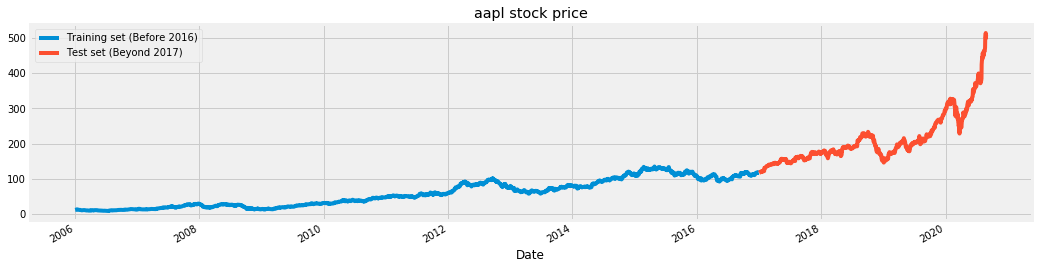

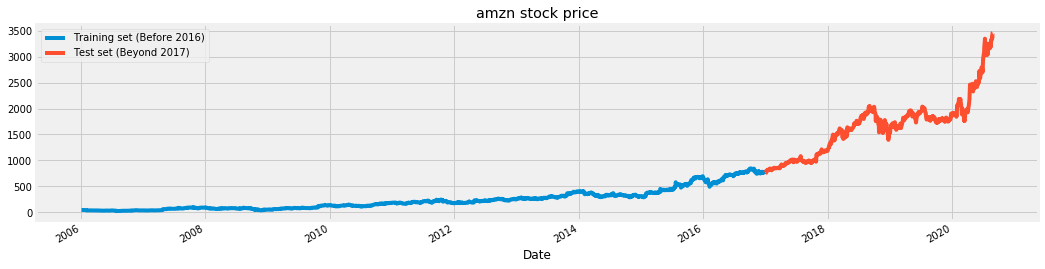

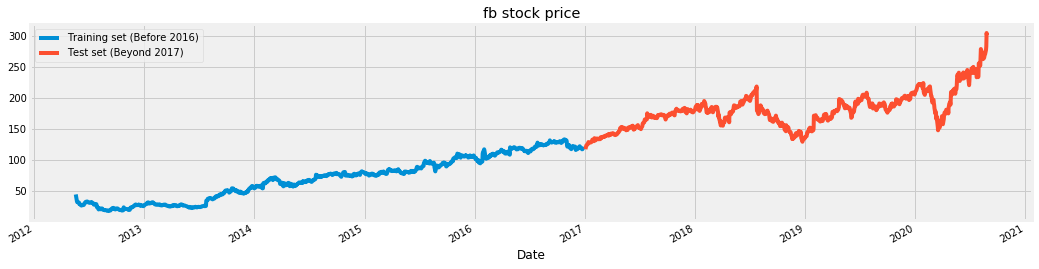

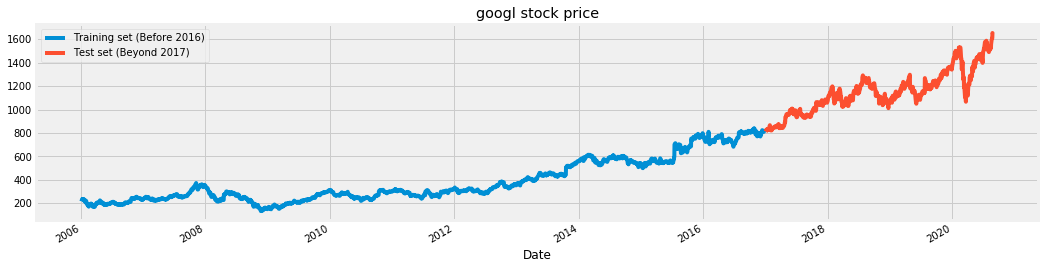

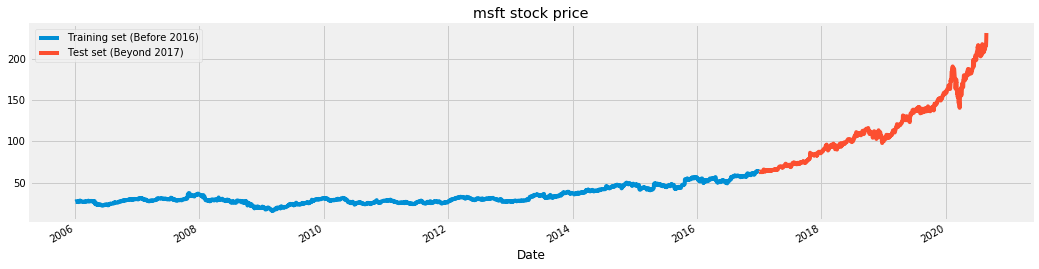

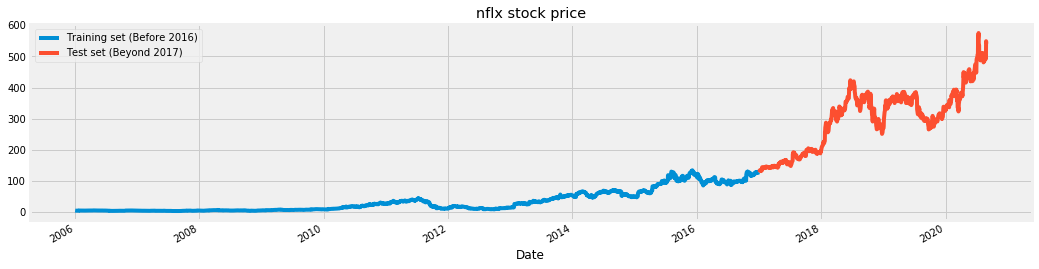

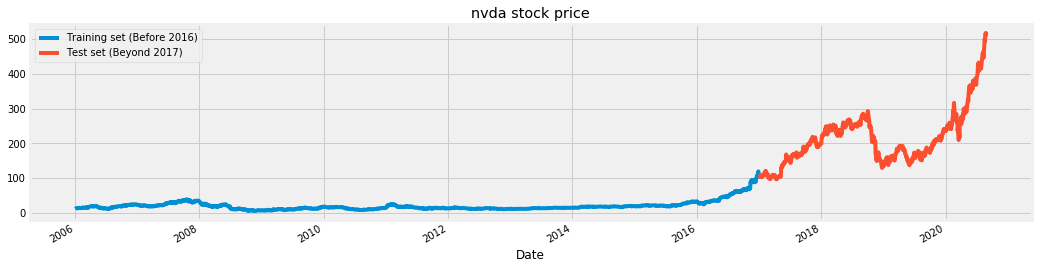

In [8]:
for stock_name, stock_data in all_data.items():
        
        # initial plots
        plot_data(stock_data, stock_name)

        # create dl data
        #X_train, y_train, X_test, sc = create_dl_train_test_split(stock_data)

        # create small single layer small rnn preds
        #small_single_layer_rnn, small_one_layer_preds = create_single_layer_small_rnn_model(X_train, y_train, X_test, sc)

        # create single layer rnn preds
        #single_layer_rnn, one_layer_preds = create_single_layer_rnn_model(X_train, y_train, X_test, sc)

        # rnn daily preds
        #rnn_model, rnn_preds = create_rnn_model(X_train, y_train, X_test, sc)

        # gru daily preds
        #gru_model, gru_preds = create_GRU_model(X_train, y_train, X_test, sc)

        # gru daily preds
        #gru_drop_model, gru_drop_preds = create_GRU_with_drop_out_model(X_train, y_train, X_test, sc)

        # yearly preds
        #yearly_preds = create_prophet_results(stock_data)

        # daily preds
        # prophet_daily_preds = create_prophet_daily_results(stock_data)

        # plot results
        #plot_results(stock_data, stock_name, small_one_layer_preds, one_layer_preds, yearly_preds, gru_drop_preds, rnn_preds, gru_preds)

In [9]:
all_data

{'aapl':                   Open        High         Low       Close     Volume  Name
 Date                                                                       
 2006-01-03   10.340000   10.678572   10.321428   10.678572  201808600  aapl
 2006-01-04   10.732857   10.854285   10.642858   10.710000  154900900  aapl
 2006-01-05   10.690000   10.700000   10.535714   10.625714  112355600  aapl
 2006-01-06   10.750000   10.957143   10.650000   10.900000  176114400  aapl
 2006-01-09   10.961429   11.028571   10.820000   10.864285  168760200  aapl
 ...                ...         ...         ...         ...        ...   ...
 2020-08-21  477.049988  499.470001  477.000000  497.480011   84513700  aapl
 2020-08-24  514.789978  515.140015  495.750000  503.429993   86484400  aapl
 2020-08-25  498.790009  500.720001  492.209991  499.299988   52873900  aapl
 2020-08-26  504.720001  507.970001  500.329987  506.089996   40755600  aapl
 2020-08-27  508.570007  509.940002  495.329987  500.040009   388881